**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 8.5 MB/s 
     |████████████████████████████████| 743 kB 58.6 MB/s 
     |████████████████████████████████| 4.9 MB 9.8 MB/s 
     |████████████████████████████████| 86 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=e5ae9a1149465e4f08b164af4ca5b35506da88b54671678b798348f42a91661e
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=8655657427faa56a399d933b50b625003438300e74c280f86931d9c9d6f86c80
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [6]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [7]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [8]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [9]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [10]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

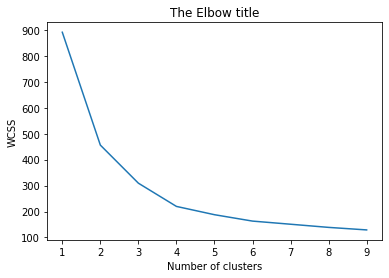

In [11]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [12]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [13]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [14]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
3,3,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...


In [15]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [16]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [17]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [18]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [19]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [20]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [60]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
#removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน']
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','ดิชั้น', "['",
                 'ดิ','ช้ัน','ซื้อ','อาหาร','ราคา','ดังนั้น','โต๊ะ','รอง','รับประทาน',
                 'แก้','ทาน','กิน','สวัสดี','รีวิว','ผม','บาท','สันทัด','review','น','กก']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [61]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [62]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(อร่อย, 9), (บ้าน, 5), (ร้านกาแฟ, 5), (กาแฟ, ..."
1,1,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ชอบ, 8), (คาเฟ่,..."
3,3,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (อร่อย, 6), (ซอย, 6), (เพื่อ..."


In [70]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('อร่อย', 9), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('กา', 3), ('ศ', 3), ('ครั้งแรก', 3), ('นะคะ', 3), ('เลือก', 3), ('บอ', 3), ('ลอง', 3), ('หา', 3), ('ดี', 3), ('น้ำ', 3), ('สาขา', 3)]

Cluster ID : 1

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2), ('ขาย', 2), ('Ochaya', 2), ('Aprilstore', 2)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ชอบ', 8), ('คาเฟ่', 6), ('แวะ', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('คน', 4), ('นึง', 4), ('อ', 4), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4), ('แนว', 4), ('กร้าน', 4), ('แถว', 4), ('เม', 4), ('ซอน', 4), ('บรรยากาศ', 4)]

Cluster ID : 3

Most common words include : [('ร้านอาหาร', 11

**Step 4 - result discussion**

VOC_6310422060


TOPIC & คำอธิบาย 

Cluster ID : 0  TOPIC>> ร้านกาแฟเจอทุกที่

* รีวิวของร้านกาแฟมีมากกว่าหนึ่งสาขา อาจอยู่ใกล้บ้าน หาได้ทั่วไป และค่อนข้างเป็นที่นิยมเพราะมีการต่อคิว

Cluster ID : 1
TOPIC>> ร้านชานมไข่มุกไต้หวัน

* รีวิวของร้านชานมไข่มุกไต้หวัน มีหลายสาขา คนสามารถแวะเข้าไปซื้อได้

Cluster ID : 2
TOPIC>> คาเฟ่มุ้งมิ้ง

* รีวิวคาเฟ๋ แต่งร้านน่ารัก มีกาแฟ เบเกอรี่ บริการ แต่เด่นๆ น่าจะเป็นเรื่องของกาแฟ เพราะมีการเอ่ยถึงมากที่สุด และเป็นร้านที่คนมักจะนั่งนานๆ กินบรรยากาศ 

Cluster ID : 3
TOPIC>>ร้านอาหารไทย

* รีวิวร้านอาหารไทยเก่าแก่ รสชาติดี สำหรับพากลุ่มเพื่อนไปทาน มีอาหารไทย ยำ และส้มตำไก่ย่าง 